#  Lesson 12 深度学习基础网络手动搭建与快速实现

&emsp;&emsp;我们尝试自己创建一个数据生成器，用于自主生成一些符合某些条件、具备某些特性的数据集。

## 一、深度学习建模实验中数据集生成函数的创建与使用   

### 1.1 回归类数据创建

#### 1.手动生成数据

&emsp;&emsp;回归类模型的数据，特征和标签都是连续型数值。


- `torch.randn(size=)` 满足标准正态分布的数据

In [1]:
# 导入相关的包
import random

import matplotlib as mpl
import matplotlib.pyplot as  plt

import numpy as  np

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset,TensorDataset,DataLoader

- 数据生成  
生成两个特征、存在偏差，自变量和因变量存在线性关系的数据集

In [2]:
num_inputs = 2
num_examples = 1000

# 2个特征，1000条数据

In [3]:
torch.manual_seed(420)

In [7]:
# 线性方程系数 2x_1 -x_2 +1 = y
w_true = torch.tensor([2., -1]).reshape(2, 1)
b_true = torch.tensor(1.)

# 特征和标签取值 
features = torch.randn(num_examples, num_inputs)  # 随机生成1000*2服从标准正态分布的数据
labels_true = torch.mm(features, w_true) + b_true

# 对标签进行干扰 
# randn() 满足标准正态分布的随机数
labels = labels_true + torch.randn(size = labels_true.shape) * 0.01

In [8]:
# 数据探索 
features[:10]

tensor([[-1.0979,  0.1825],
        [-0.2895, -0.8303],
        [ 1.4373,  1.6355],
        [ 0.2984, -0.3024],
        [-1.1839,  0.8756],
        [ 1.1910, -0.9895],
        [-1.1805,  0.3646],
        [ 1.6526,  2.8122],
        [-0.8005,  1.6628],
        [-0.2353, -1.6575]])

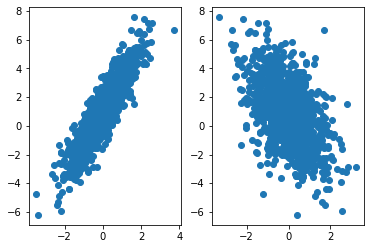

In [10]:
#————————————————————————————绘图————————————————————————————
plt.subplot(121)  # 1行1列 第一个图
plt.scatter(features[:,0],labels)
plt.subplot(122)
plt.scatter(features[:,1],labels)

不难看出，两个特征和标签都存在一定的线性关系，并且跟特征的系数绝对值有很大关系。当然，若要增加线性模型的建模难度，可以增加扰动项的数值比例，从而削弱线性关系。

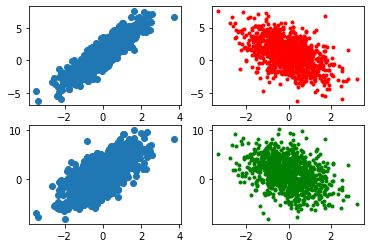

In [20]:
torch.manual_seed(420)

# 修改因变量 加入影响较大的扰动项
labels1 = labels_true + torch.randn(size=labels_true.shape)*2


#————————————————————————————可视化展示————————————————————————————
# 竖向对比

# 扰动较小
# 扰动较小的情况
plt.subplot(221)
plt.scatter(features[:, 0], labels)             # 第一个特征和标签的关系
plt.subplot(222)
plt.plot(features[:, 1], labels, 'r.')          # 第二个特征和标签的关系

# 扰动较大的情况
plt.subplot(223)
plt.scatter(features[:, 0], labels1)             # 第一个特征和标签的关系
plt.subplot(224)
plt.plot(features[:, 1], labels1, 'g.')          # 第二个特征和标签的关系

当然，我们也能生成非线性关系的数据集，此处我们创建满足$y=x^2+1$规律的数据集。

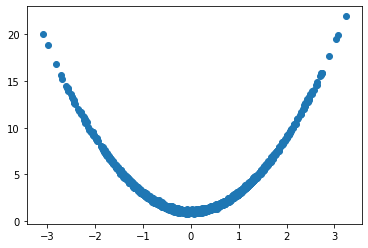

In [35]:
# 设置随机数种子
torch.manual_seed(420)   

num_inputs = 2               # 两个特征
num_examples = 1000          # 总共一千条数据

# 线性方程系数
w_true = torch.tensor(2.)
b_true = torch.tensor(1.)

# 特征和标签取值
features = torch.randn(num_examples, num_inputs)
# y = w1x1^2 +w1x2^2 +b
labels_true = torch.pow(features, 2) * w_true + b_true
labels = labels_true + torch.randn(size = labels_true.shape) * 0.1

# 可视化展示
plt.scatter(features, labels)

#### 2.创建生成回归类数据的函数

- 生成满足$y=2x_1-1x_2+1$


In [4]:
import torch
w = torch.tensor([2,-1,1,2])
w[:-1]

# 提取除去去最后一个以外的所有元素

tensor([ 2, -1,  1])

In [22]:
def tensorGenReg(num_examples=1000,w = [2,-1,1],bias = True,delta=0.01,deg=1):
    """回归类数据集创建函数。

    :param num_examples: 创建数据集的数据量
    :param w: 包括截距的（如果存在）特征系数向量
    :param bias：是否需要截距
    :param delta：扰动项取值
    :param deg：方程次数
    :return: 生成的特征张和标签张量
    """
    if bias == True:
        num_inputs = len(w) - 1   # 原特征张量w中包含b的系数，需要去掉一列
        features_true = torch.randn(num_examples,num_inputs)   
        w_true = torch.tensor(w[:-1]).reshape(-1,1).float()  # 不包含全是1的列的特征张量
        b_true = torch.tensor(w[-1]).float()  # 提取原来w的最后一个元素为截距

        # 若输入特征只有1个，则不能使用矩阵乘法    
        if num_inputs == 1:  
            labels_true = torch.pow(features_true,deg) * w_true + b_true
        else:
            labels_true = torch.mm(torch.pow(features_true,deg),w_true) + b_true

        # bias=True 需要加上全1列
        features = torch.cat((features_true,torch.ones(len(features_true),1)),1)  # 在水平方向上添加一列
        labels = labels_true + torch.randn(size=labels_true.shape) * delta  # 加扰动项

    else:   # 截距项的信息包含在w中
        num_inputs = len(w)
        features = torch.randn(num_examples,num_inputs)
        w_true = torch.tensor(w).reshape(-1,1).float()
        # 只有一个特征的情况
        if num_inputs == 1:
            labels_true = torch.pow(features, deg) * w_true
        else:
            labels_true = torch.mm(torch.pow(features, deg), w_true)
        labels = labels_true + torch.randn(size = labels_true.shape) * delta

    return features, labels  


# 无法创建带有交叉项的方差    
#       

- 测试函数性能
  查看扰动较小的情况

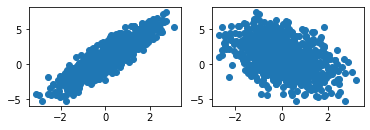

In [36]:
#————————————————————————————扰动较小delta=0.01————————————————————————————
# 设置随机数种子
torch.manual_seed(420)   

# 扰动项取值为0.01
f, l = tensorGenReg(delta=0.01)

# 绘制图像查看结果
plt.subplot(223)
plt.scatter(f[:, 0], l)             # 第一个特征和标签的关系
plt.subplot(224)
plt.scatter(f[:, 1], l)          # 第二个特征和标签的关系

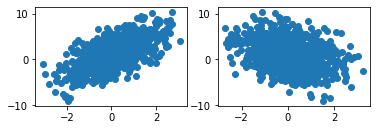

In [34]:
#————————————————————————————扰动较大————————————————————————————
# 设置随机数种子
torch.manual_seed(420)   

# 扰动项取值为2
f, l = tensorGenReg(delta=2)

# 绘制图像查看结果
plt.subplot(223)
plt.scatter(f[:, 0], l)             # 第一个特征和标签的关系
plt.subplot(224)
plt.scatter(f[:, 1], l)          # 第二个特征和标签的关系

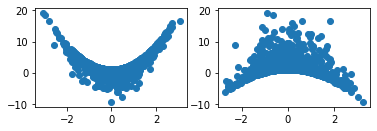

In [37]:
#————————————————————————————特征和标签满足二阶关系————————————————————————————

# 设置随机数种子
torch.manual_seed(420)   

# 2阶方程
f, l = tensorGenReg(deg=2)

# 绘制图像查看结果
plt.subplot(223)
plt.scatter(f[:, 0], l)             # 第一个特征和标签的关系
plt.subplot(224)
plt.scatter(f[:, 1], l)          # 第二个特征和标签的关系

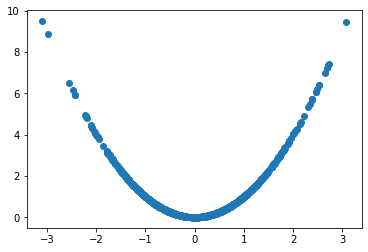

In [38]:
#————————————————————————————只有一个特征————————————————————————————
# 设置随机数种子
torch.manual_seed(420)   

# 2阶方程
f, l = tensorGenReg(w=[1], deg=2, bias=False)
plt.scatter(f, l)

### 1.2 分类数据集创建方法

- 分类模型数据的标签是离散值

#### 1.手动创建分类数据集

- `torch.normal(mean,std,size=())`创建服从某种正态分布的随机
  - 不输入size,，默认size=(mean,std)
  - normal函数的均值参数位、标准差参数位都允许输入高维数组，从而最终输出结果也是形状相同的高维数组；
- 一般来说，约定俗成的方式，是针对多分类问题，类别标记从0开始依次递增；
- 对于PyTorch来说，分类问题标签要求是默认整型。
- `torch.ones(n),torch.zeros(n)`
- `torch.full_like(label1, 2) `形容label1,全部填充为2
- `torch.cat((data1,data2)) `默认dim=0 垂直方向上拼接
  - dim=1 在水平方向上拼接

In [5]:
torch.randn(3,4)  # 均值是3,标准差是4，size不输入默认为（3,4）

tensor([[-0.1437,  0.2765, -1.1443, -0.5227],
        [-0.0514, -0.1497, -0.2754, -1.2850],
        [-0.8385,  1.3600, -0.4374,  0.7934]])

In [41]:
torch.randn(4,2)  # 均值是4,标准差是2

tensor([[-0.3149,  0.0404],
        [ 0.2353, -1.7004],
        [-0.7954,  0.7032],
        [ 2.2071,  1.0092]])

In [40]:
torch.normal(4, 2, size=(10,2))

tensor([[6.6112, 1.6668],
        [5.4298, 5.6647],
        [4.8992, 2.5025],
        [2.8745, 6.8008],
        [3.5389, 4.5651],
        [4.7916, 6.4664],
        [2.0969, 3.8913],
        [6.8612, 7.1782],
        [3.2981, 4.4307],
        [5.4252, 2.9883]])

建一个拥有两个特征的三分类的数据集，每个类别包含500条数据，
- 第一个类别的两个特征都服从均值为3、标准差为2的正态分布，label=0
- 第二个类别的两个特征都服从均值为0、标准差为2的正态分布,label=1
- 第三个类别的两个特征都服从均值为-3、标准差为2的正态分布,label=2

In [6]:
# 设置随机数种子
torch.manual_seed(420)   

# 创建初始标记值
num_inputs = 2
num_examples = 500

# 创建自变量簇
data0 = torch.normal(3, 2, size=(num_examples, num_inputs))
data1 = torch.normal(0, 2, size=(num_examples, num_inputs))
data2 = torch.normal(-3, 2, size=(num_examples, num_inputs))

# 创建标签
label0 = torch.zeros(500)
label1 = torch.ones(500)
label2 = torch.full_like(label1, 2)

# 合并生成最终数据
features1 = torch.cat((data0, data1, data2)).float()
labels1 = torch.cat((label0, label1, label2)).long().reshape(-1, 1)

In [7]:
#————————————————————————————cat函数的使用————————————————————————————
torch.cat((data0, data1, data2))

tensor([[ 2.9859,  4.0089],
        [ 4.3407,  2.2343],
        [ 3.0605,  3.7653],
        ...,
        [-2.5378, -4.8594],
        [-3.2722,  0.2208],
        [-4.0295, -5.8764]])

In [8]:
torch.cat((data0, data1, data2),dim=1)

tensor([[ 2.9859,  4.0089,  1.4105,  3.7466, -2.1908, -6.0227],
        [ 4.3407,  2.2343, -1.6447, -0.1199, -2.5908, -3.6013],
        [ 3.0605,  3.7653,  0.8139, -3.8657, -3.2059, -3.7912],
        ...,
        [ 3.5234,  4.2765,  0.9623,  0.0861, -2.5378, -4.8594],
        [ 4.5807,  4.4728, -1.5465, -2.2140, -3.2722,  0.2208],
        [ 2.7256,  4.4876, -4.6681,  1.3935, -4.0295, -5.8764]])

In [44]:
# 设置随机数种子
torch.manual_seed(420)   

# 创建初始标记值
num_inputs = 2
num_examples = 500

# 创建自变量簇
data0 = torch.normal(4, 2, size=(num_examples, num_inputs))
data1 = torch.normal(-2, 2, size=(num_examples, num_inputs))
data2 = torch.normal(-6, 2, size=(num_examples, num_inputs))

# 创建标签  
label0 = torch.zeros(500)
label1 = torch.ones(500)
label2 = torch.full_like(label1, 2)


# 合并生成最终数据  竖向拼接
features = torch.cat((data0, data1, data2)).float()
labels = torch.cat((label0, label1, label2)).long().reshape(-1, 1)
features
labels

tensor([[0],
        [0],
        [0],
        ...,
        [2],
        [2],
        [2]])

- 数据探索

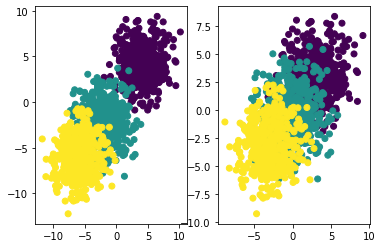

In [54]:

# 可视化展示
plt.subplot(121)
plt.scatter(features[:, 0], features[:, 1], c = np.squeeze(labels))             
plt.subplot(122)
plt.scatter(features1[:, 0], features1[:, 1], c = np.squeeze(labels1))

# 图二中心点更加接近，边界更加不明显

#### 2.创建生成分类数据的函数

&emsp;&emsp;我们希望找到一个变量可以控制数据整体离散程度，也就是后续建模的难以程度。这里我们规定，如果每个分类数据集中心点较近、且每个类别的点内部方差较大，则数据集整体离散程度较高，反之离散程度较低。

- tensorGenCla产生的每个簇都服从同样类型的正态分布，由deg_dispersion=[mean,std]

- emtpy() 创建一个空的张量，有形状

In [67]:
def tensorGenCla(num_examples = 500, num_inputs = 2, num_class = 3, deg_dispersion = [4, 2], bias = False):    
    """分类数据集创建函数。
    
    :param num_examples: 每个类别的数据数量
    :param num_inputs: 数据集特征数量
    :param num_class：数据集标签类别总数
    :param deg_dispersion：数据分布离散程度参数，需要输入一个列表，其中第一个参数表示每个类别数组均值的参考、第二个参数表示随机数组标准差。
    :param bias：建立模型逻辑回归模型时是否带入截距
    :return: 生成的特征张量和标签张量，其中特征张量是浮点型二维数组，标签张量是长正型二维数组。
    """ 

    cluster_l = torch.empty(num_examples,1)  # 每一类标签张量的形状
    mean_ = deg_dispersion[0]
    std_ = deg_dispersion[1]
    lf = []  # 用于存储每一类特征张量的列表容器
    ll = []  # 用于存储每一类标签张量的列表容器
    k = mean_ * (num_class-1) / 2   # 每一类特征张量均值的惩罚因子


    for i in range(num_class):
        data_temp = torch.normal(i*mean_ - k,std_,size=(num_examples,num_inputs)) # 生成每一类张量
        lf.append(data_temp)
        labels_temp = torch.full_like(cluster_l, i)
        ll.append(labels_temp)   # 将labels_temp追加到ll

    features = torch.cat(lf).float()
    labels = torch.cat(ll).long()
    
    if bias == True:
        features = torch.cat((features, torch.ones(len(features), 1)), 1)              # 在特征张量中添加一列全是1的列
    return features, labels
        

- 转换到围绕0附近均匀分布的数据
    - k = mean_ * (num_class-1) / 2
    - i*mean_ - k  
    - 例如：
[0, 4, 8]     ->     [-4, 0, 4]    -> [-1, 0 ,1]  
[0, 4, 8, 12, 16]     ->       [-8, -4, 0, 4, 8]      ->        [-2, -1, 0, 1, 2]

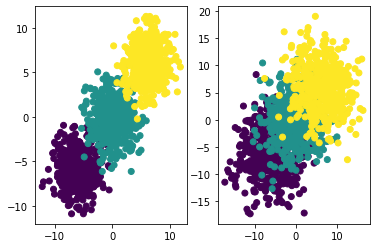

In [68]:
#————————————————————————————测试函数性能————————————————————————————

# 设置随机数种子
torch.manual_seed(420)   

# 创建数据
f, l = tensorGenCla(deg_dispersion = [6, 2])          # 离散程度较小
f1, l1 = tensorGenCla(deg_dispersion = [6, 4])        # 离散程度较大

# 绘制图像查看
plt.subplot(121)
plt.scatter(f[:, 0], f[:, 1], c = np.squeeze(l))
plt.subplot(122)
plt.scatter(f1[:, 0], f1[:, 1], c = np.squeeze(l1))

### 2.创建小批量切分函数

&emsp;&emsp;目前为止，我们判断小批量梯度下降（MBGD）是较为“普适”的优化算法，它既拥有随机梯度下降（SGD）的能够跨越局部最小值点的特性，同时又和批量梯度下降（BGD）一样，拥有相对较快的收敛速度（虽然速度略慢与BGD需要对函数进行分批量）。而在小批量梯度下降过程中，我们的切分，因此，在手动实现各类深度学习基础算法之前，我们需要定义数据集小批量切分的函数。

- shuffle过程
- `torch.index_select(tensow,dim,index)`

In [69]:
l = list(range(5))
random.shuffle(l)
l

[2, 1, 4, 3, 0]

In [70]:
def data_iter(batch_size, features, labels):
    """
    数据切分函数
    
    :param batch_size: 每个子数据集包含多少数据
    :param featurs: 输入的特征张量
    :param labels：输入的标签张量
    :return l：包含batch_size个列表，每个列表切分后的特征和标签所组成 
    """
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 打乱所有的样本
    l = []

    for i in range(0,num_examples,batch_size):  # 每跨一步 就是跨一个batch_size
        j = torch.tensor(indices[i:min(i + batch_size,num_examples)])
        l.append([torch.index_select(features,0,j),torch.index_select(labels,0,j)])
    return l


In [71]:
for i in range(0, 5, 2):
    print(i)

0
2
4


In [74]:
# 设置随机数种子
torch.manual_seed(420)  

# 生成二分类数据集
features, labels = tensorGenCla()   
features[:5]

tensor([[-4.0141, -2.9911],
        [-2.6593, -4.7657],
        [-3.9395, -3.2347],
        [-5.0262, -2.5792],
        [-0.3817, -3.1295]])

In [75]:
torch.tensor(l[0:2])

tensor([2, 1])

## 二、可视化工具TensorBoard用法

&emsp;&emsp;Tensorboard原本是TensorFlow的可视化工具，而目前在TensorboardX工具的加持下，其他深度学习计算框架也可使用TensorBoard工具进行可视化操作了。

![15](https://i.loli.net/2021/02/04/YaVEoCzJLrPNRjm.jpg)

In [ ]:
# 随机模块
import random

# 绘图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# numpy
import numpy as np

# pytorch
import torch
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import Dataset,TensorDataset,DataLoader

In [4]:
# pip install -i https://pypi.tuna.tsinghua.edu.cn/simple --trusted-host pypi.tuna.tsinghua.edu.cn torchvision

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ---------------------------------------- 1.1/1.1 MB 6.1 MB/s eta 0:00:00


In [ ]:
#————————————————————————————安装tensorboardX————————————————————————————
# !pip install -i https://pypi.tuna.tsinghua.edu.cn/simple --trusted-host pypi.tuna.tsinghua.edu.cn tensorboard

In [2]:
import tensorboardX

c:\Users\HP\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\HP\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\HP\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
from torch.utils.tensorboard import SummaryWriter

#### 1.SummaryWriter类与Tensorboard的基本使用

&emsp;&emsp;在进行建模过程可视化展示的过程中，核心使用的类就是SummaryWriter类，通过该类的使用，我们可以记录关键运算关系、模型数值指标等，进而可以进行展
示。   
&emsp;&emsp;使用SummaryWriter进行记录并读取结果的一般过程如下：   

![22](https://i.loli.net/2021/02/04/CcYrna16sF7842L.jpg)

- `add_scalar(记录对象名称,y值,x值)` 以图像的性质存储在服务器上
- 属性`log_dir` 查看summary对象记录文件的位置


**进行Tensorboard步骤**
- 启动服务读取文件  
在vscode的当前目录的终端下输入：`tensorboard --logdir="test"`,开启服务

- 进入6006端口页面  
打开浏览器，在地址栏输入localhost:6006即可进入到tensorboard展示页面

In [4]:
#————————————————————————————实例化summarywriter————————————————————————————
writer = SummaryWriter(log_dir='test')

In [5]:
writer.log_dir       
# 通过log_dir

'test'

- 记录数据

In [6]:
#————————————————————————————记录数据————————————————————————————
for i in range(10):
    writer.add_scalar('mul', i*i, i)
    writer.add_scalar('mull', 3*i, i)

此处我们使用了add_scalar方法进行数据记录，该方法用于记录一组组标量，在实际记录过程中，通过迭代的方式逐个增加。其中，第一个参数代表改组记录的名称（也就是生成图像的名称），第二个参数代表y值，第三个参数代表x值。完成记录后，即可读取文件查看记录结果。

- 启动服务读取文件
在vscode的当前目录的终端下输入：`tensorboard --logdir="test"`,开启服务

- 进入6006端口页面

&emsp;&emsp;打开浏览器，在地址栏输入localhost:6006即可进入到tensorboard展示页面